In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import math
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from pathlib import Path
from utils import compute_K, Ustat_MMD
from mmdvar import IncomMMDVar, ComMMDVar, h1_mean_var_gram

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
# Function to generate samples from multivariate normal distribution
def sample_mvn(key, mean, cov, num_samples):
    return jax.random.multivariate_normal(mean=mean, cov=cov, shape=num_samples, key=key)

In [6]:
def MAPE(true, est):
    return jnp.abs(true - jnp.average(est)) / true

In [7]:
##########  Simulation 1  ############
#### decreasing signal as n grows ####
######################################
key = jax.random.PRNGKey(42)

# Parameter Settings 
n_iters = 1000 # Number of times to estimate MMD
sigma0 = 1.0 # Default bandwidth for Gaussian kernel 
d = 5 # dimension of data 

# Array to store MMD values
mmd_samples = jnp.zeros(n_iters)
full = jnp.zeros(n_iters) # Complete MMD Variance Estimate(Ours)
Liu = jnp.zeros(n_iters)  # V-stats MMD variance Estimate(Liu et al. 2020)
suth = jnp.zeros(n_iters)# Incomplete MMD Variance Estimate(Sutherland et al. 2019)
Vm = jnp.zeros(n_iters)
# com_2 = jnp.zeros(n_iters)

full_variance_estimates = []
# complete_variance_estimates = []
sutherland_estimates = []
vm_estimates = []
liu_estimates = []

num_samples = [64, 128, 256, 512, 1024, 2048]

for sample_size in tqdm(num_samples):
    
    print("number of samples : ",sample_size)
    delta = 3.0
    # First dataset
    mean1 = jnp.zeros(d)
    cov = jnp.eye(d)

    # Second dataset
    mean2 = jnp.zeros(d) + delta
    
    # Monte Carlo simulation to estimate MMD values
    for i in tqdm(range(n_iters)):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        
        # Mean Difference 
        X = sample_mvn(subkey1, mean1, cov, (sample_size,))
        Y = sample_mvn(subkey2, mean2, cov, (sample_size,))

        tKxx, tKyy, Kxy = compute_K(X, Y, sigma0, bias=False)
        Kxx, Kyy, Kxy = compute_K(X, Y, sigma0, bias=True)
        m = Kxx.shape[0]
        n = Kyy.shape[0]
        mmd_value = Ustat_MMD(tKxx, tKyy, Kxy, m, n)

        mmd_samples = mmd_samples.at[i].set(mmd_value)
        full = full.at[i].set(ComMMDVar(tKxx, tKyy, Kxy))
        # com_2 = com_2.at[i].set(compute_unbiased_var (Kxx, Kyy, Kxy, m ,n, complete = False))
        suth = suth.at[i].set(IncomMMDVar(tKxx, tKyy, Kxy))
        Liu = Liu.at[i].set(h1_mean_var_gram(Kxx, Kyy, Kxy, is_var_computed=True, use_1sample_U=True)[1])

    # Compute estimated variance of MMD
    mmd_variance = jnp.var(mmd_samples, ddof=1)
    
    full_variance_estimates.append(MAPE(mmd_variance, full))
    # complete_variance_estimates.append(jnp.abs(mmd_variance - jnp.average(com_2))/mmd_variance)
    sutherland_estimates.append(MAPE(mmd_variance, suth))
    liu_estimates.append(MAPE(mmd_variance, Liu))
    vm_estimates.append(MAPE(mmd_variance, Vm))

    print("The average of MMDu",jnp.average(mmd_samples))
    print("True Variance of MMD:", mmd_variance)

    # Compare the results
    print()
    print("How accurate estimators estimate the variance : estimator/true")
    print(f"Full Variance Estimate (Ours 8): {MAPE(mmd_variance, full)}")
    # print(f"Complete Variance Estimate (Ours 2): {MAPE}")
    print(f"Sutherland (2019) : {MAPE(mmd_variance, suth)}")
    print(f"Incomplete Variance Estimate (Liu et al. 2): {MAPE(mmd_variance, Liu)}")
    print(f"Vm: {MAPE(mmd_variance, Vm)}")
    print()

2023-11-20 15:00:47.594223: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/6 [00:00<?, ?it/s]

number of samples :  64


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.03575610108712097
True Variance of MMD: 2.5867400256368043e-05

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.02725298413296959
Sutherland (2019) : 0.0228889574973578
Incomplete Variance Estimate (Liu et al. 2): 0.030917119757615966
Vm: 1.0

number of samples :  128


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.03580450919985801
True Variance of MMD: 1.1663561217312194e-05

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.006801199595727002
Sutherland (2019) : 0.008004279679426074
Incomplete Variance Estimate (Liu et al. 2): 0.04386619867177383
Vm: 1.0

number of samples :  256


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.035815932769253
True Variance of MMD: 5.9872633221754095e-06

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.050945552673443854
Sutherland (2019) : 0.050653882126265135
Incomplete Variance Estimate (Liu et al. 2): 0.03204573711970185
Vm: 1.0

number of samples :  512


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.035703219872324
True Variance of MMD: 2.818146825967954e-06

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.016636180036081145
Sutherland (2019) : 0.016559338768761648
Incomplete Variance Estimate (Liu et al. 2): 0.00676962539376814
Vm: 1.0

number of samples :  1024


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.035727576039217314
True Variance of MMD: 1.430209693169993e-06

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.03795965399170305
Sutherland (2019) : 0.037940827913366226
Incomplete Variance Estimate (Liu et al. 2): 0.033644042480120484
Vm: 1.0

number of samples :  2048


  0%|          | 0/1000 [00:00<?, ?it/s]

The average of MMDu 0.03578793364564551
True Variance of MMD: 6.953266332421482e-07

How accurate estimators estimate the variance : estimator/true
Full Variance Estimate (Ours 8): 0.012331736886929213
Sutherland (2019) : 0.012326960653659437
Incomplete Variance Estimate (Liu et al. 2): 0.01138290971985521
Vm: 1.0



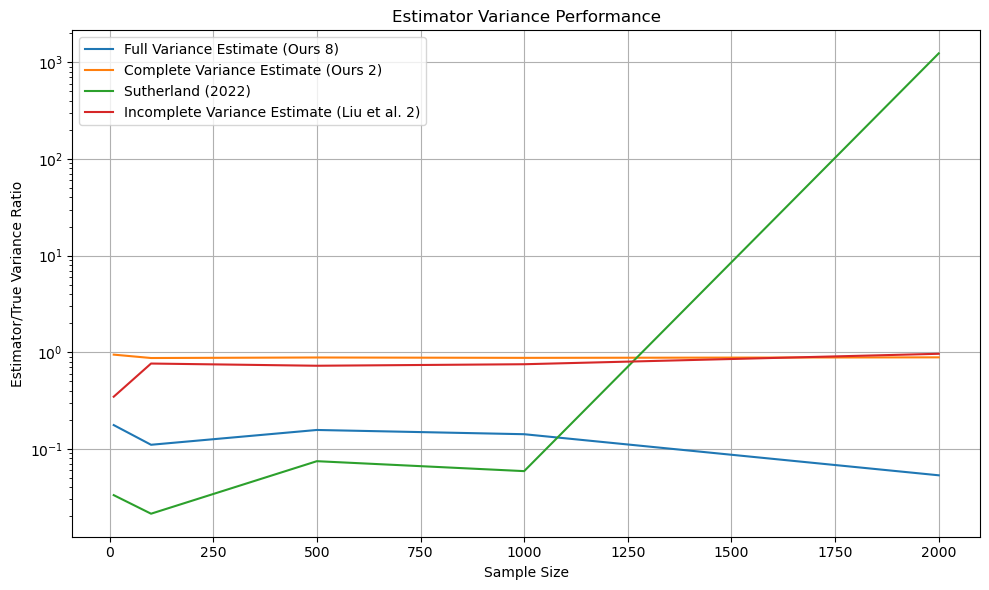

In [8]:
import matplotlib.pyplot as plt

# Data
sample_sizes = [10, 100, 500, 1000, 2000]
full_variance_estimates = [0.17655509368585445, 0.11044403689984993, 0.15714277058262002, 0.14202993663589988, 0.05336349313853741]
complete_variance_estimates = [0.945722031121335, 0.8725068453005361, 0.8833989844950265, 0.8757223919743891, 0.8863523431043184]
sutherland_estimates = [0.03326352570744373, 0.02137627443252068, 0.07469605649442351, 0.05894031950457824, 1238.4849737345553]
incomplete_variance_estimates = [0.34708349699653546, 0.7648303734535044, 0.725764638276863, 0.7523154270156995, 0.964991847340291]

# Create plots for each estimator
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, full_variance_estimates, label='Full Variance Estimate (Ours 8)')
plt.plot(sample_sizes, complete_variance_estimates, label='Complete Variance Estimate (Ours 2)')
plt.plot(sample_sizes, sutherland_estimates, label='Sutherland (2022)')
plt.plot(sample_sizes, incomplete_variance_estimates, label='Incomplete Variance Estimate (Liu et al. 2)')

# Set plot labels and title
plt.xlabel('Sample Size')
plt.ylabel('Estimator/True Variance Ratio')
plt.yscale('log')  # You can choose to use a logarithmic scale if needed
plt.title('Estimator Variance Performance')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
